In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 2]
from tqdm import tqdm
import numpy as np
from data_processing.neural_networks.RL_Reinforced_Learning.Rl_function_approximation import env_approx
from data_processing.Regression.coarse_coding import tiles
from IPython.display import clear_output
clear_output()
#from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

https://github.com/MeepMoop/tilecoding/tree/master

If state space is huge, we want to approximate $v_\pi(s)$ with a function $\hat v(s,\vec{w})$ that can generalize.

$\vec{w} \in \R^d$ is a vector that holds parameters of $\hat v(s,\vec{w})$ and we assume that $ d \ll |S|$. 

Downside of this generalization is that if function generalizes $S_i$ and $S_j$, by updating function value for $\hat v(s = S_i,\vec{w})$ will also affect output for other state

## _Value error_

For individual state $s$ we can write a value error, that shows how good is the approximation:
$$ve(s,\vec{w}) = v_\pi(s)-\hat v(s,\vec{w})$$
We could write an global Value error $\overline{VE}(\vec{w})$, which sums all state value errors (absolute values or powers of 2), but since states are coupled via generalization, we should assign importance for more common states:

$$\overline{VE}(\vec{w}) = \sum_{s \in S} \mu(s)\cdot ve(s,\vec{w})^2 = \sum_{s \in S} \mu(s)\bigg[v_\pi(s)-\hat v(s,\vec{w})\bigg]^2$$

where $\mu(s)$ , for example, is a distribution of time spend on each state $s$


## Stochastic Gradient Descent (SGD)

Gradient of a function $f(\vec{w}):\nabla_{\vec{w}} f(\vec{w})$ shows direction in space of $\vec{w}$ which increases $f(\vec{w})$ the most. 

Conversely, reversed gradient $-\nabla_{\vec{w}} f(\vec{w})$ shows direction of reduction of $f(\vec{w})$

Optimization of $\hat v(s,\vec{w})$, with a goal of better approximation, can be done via gradient descent (GD) by minimizing $\overline{VE}(\vec{w})$.

Particularly this is done by introducing new data into optimization and by it improving current version of weights $\vec{w}_t$ to a better set of weights $\vec{w}_{t+1}$. 

Classic GD updates weights by solving optimization step for all states ${s \in S}$ simultaneously.
$$\vec{w}_{t+1} = \vec{w}_{t} - \alpha \cdot \nabla_{\vec{w}}\big[\overline{VE}(\vec{w}) \big]$$
If we perform this process incrementally for individual state $S_t$ this process is called Stochastic Gradient Descent -  SGD.
$$\vec{w}_{t+1} = \vec{w}_{t} - \alpha \cdot \nabla_{\vec{w}_t} \big[ve(S_t,\vec{w}_t)^2 \big] $$

where $\alpha$ is "step size" or "learning rate". Since we know that value error is quadratic, we can pick a convenient value of $\frac{\alpha}{2}$ for the following chain rule:

$$\vec{w}_{t+1} = \vec{w}_{t} - \frac{1}{2} \alpha\nabla_{\vec{w}_t}\bigg[v_\pi(S_t)-\hat v(S_t,\vec{w}_t)\bigg]^2=$$
$$ = \vec{w}_{t} + \alpha \cdot \bigg[v_\pi(S_t)-\hat v(S_t,\vec{w}_t)\bigg]\cdot \nabla_{\vec{w}_t} \hat v(S_t,\vec{w}_t)$$

Small step/learning rate is necessary since we are observing only a subset of states, which do not represent function globally - fully fixing error on one step/state does not fix other states

We also dont know true value of $v_\pi(s)$, only an estimate. Lets call it $U_t$, so:
$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \nabla_{\vec{w}_t} \hat v(S_t,\vec{w}_t)}$$

Monte Carlo (MC) method estimates true expected discounted reward $U_t = G_t$ and is expected to converge to local optimum:
$$ \vec{w} \leftarrow \vec{w} = \alpha \big[ \underbrace{G_t}_{\text{target}}- \hat v(S,\vec{w}) \big] \cdot \nabla_{\vec{w}_t} \hat v(S,\vec{w})$$

Bootstrapping methods (TD or DP) have target value rewards that are are biased with respect to $\vec{w}_t$:
$$ \text{[TD(0) example]: } \vec{w} \leftarrow \vec{w} = \alpha \big[ \underbrace{R + \gamma \hat v(S^\prime,\vec{w})}_{\text{target}}- \hat v(S,\vec{w}) \big] \cdot \nabla_{\vec{w}_t} \hat v(S,\vec{w})$$
which makes then only 'semi-gradient methods' and they have no convergence guarantees. But in practice they still converge with linear cases. It is important since ability to work online is very beneficial. 

## Linear Methods
$\hat v(\cdot, \vec{w})$ is a linear combination of basis functions $\vec{x}(s) = \{x_1(s), x_2(s),\dots\}^T$
$$\hat v(s, \vec{w}) = \vec{w}^T \vec{x}(s) = \sum_{i = 1}^d w_i x_i(s)$$ 
Gradient is:
$$\nabla_{\vec{w}} \hat v(s, \vec{w}) = \vec{x}(s) $$

so SGD update is

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$

For TD(0) method under linear approximation:

$$\vec{w}_{t+1} = \vec{w}_t + \alpha \big[ \underbrace{R_{t+1} + \gamma \hat v(S_{t+1}, \vec{w}_t) }_{\text{target}}- \hat v(S_t,\vec{w}_t) \big] \cdot \vec{x}(S_t) = $$
$$= \vec{w}_t + \alpha \big[R_{t+1} + \gamma \vec{w}_t^T \vec{x}(S_{t+1})  - \vec{w}_t^T \vec{x}(S_t) \big] \cdot \vec{x}(S_t) = $$
$$= \vec{w}_t + \alpha \big[R_{t+1} + \gamma \vec{w}_t^T \vec{x}_{t+1}  - \vec{w}_t^T \vec{x}_t \big] \cdot \vec{x}_t = $$
$$ = 
\vec{w}_t + \alpha \big[R_{t+1}\vec{x}_t -\vec{x}_t(\vec{x}_t- \gamma \vec{x}_{t+1})^T \vec{w}_t $$

When $\vec{w}$ has reached steady state (convergence)
$$\mathbb{E}[\vec{w}_{t+1}|\vec{w}_t] = \vec{w}_t  + \alpha \bigg[ \mathbb{E}[R_{t+1} \vec{x}_t] - \mathbb{E}[\vec{x}_t(\vec{x}_t- \gamma \vec{x}_{t+1})^T]) \bigg] =$$
$$ =  \vec{w}_t + \alpha (\vec{b}- A \vec{w}_t)$$
which converged to $\vec{w}_{TD}$
$$\vec{w}_{TD} = \vec{w}_{TD}   + \alpha (\vec{b}- A \vec{w}_{TD}) \rightarrow$$
$$\vec{0} = \vec{b}- A \vec{w}_{TD}\rightarrow$$
$$ \vec{w}_{TD} = A^{-1}\vec{b}$$
which is a TD _fixed point_. This point is within a certain radius of global minimum. Radius reduces as $\frac{1}{1-\gamma}$

## Polynomials
each state -> k numbers: $\{s_1, s_2,\dots, s_k\}$
for k-dimensional state space, each order $n$ poly can be written as:
$$x_i(s) = \Pi_{k=1}^k s_j^{c_{i,j}}$$
$$c_{i,j} = \{0,1,\dots, n\}$$
i.e
$$k = 2; \ S \rightarrow \{s_1,s_2\}; \ c = 2$$

$$\vec{x} = \{1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2\}$$
$$x_0(s) = 1 = s_1^0s_2^0 \rightarrow c_1 = \{0,0\}$$
$$x_1(s) = s_1 = s_1^1s_2^0 \rightarrow c_2 = \{1,0\}$$
$$\dots$$
$$x_8(s) = s_1^2s_2 = s_1^2s_2^1 \rightarrow c_8 = \{2,1\}$$
$$x_9(s) = s_1^2s_2^2 = s_1^2s_2^1 \rightarrow c_9 = \{2,2\}$$

Cross terms $s_i^a s_j^b$ allows capture state 'interaction'

## Fourier Basis

$$\vec{s} = \{s_1,s_2,\dots, s_k\}^T; s_i \in [0,1]$$
$$x_i(s) = cos(\pi \vec{s}^T \vec{c}^i)$$
$$\vec{c}^i = \{c_1^i,\dots, c_k^i\}^T; \ c_j^i \in \{0,\dots,n\}$$

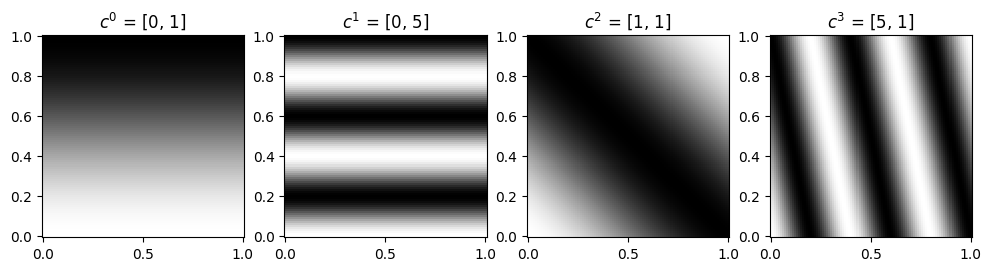

In [21]:
cs = [[0,1],[0,5],[1,1],[5,1]]

def x(s1, s2, c):
    a,b = c
    return np.cos(np.pi * (a* s1 + b* s2))

N = 100
S1,S2 = np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N))

fig, axs = plt.subplots(1,4, figsize = (12,3))
axs = axs.flatten()

for i,a in enumerate(axs):
    a.pcolormesh(S1,S2,x(S1,S2,cs[i]),cmap='gray')
    a.set_title('$c^'+ str(i)+ '$ = '+ f'{cs[i]}')
    a.set_aspect(1)

## Coarse Coding
Binary features. 

Space is divided in overlapping regions points can be 'present' in multiple neighboring regions, which is one-hot encoded. This allows to keep information about proximity of states (generalization). But it cannot differentiate between states that are too close.

In [ ]:
def square_wave(x):
    if x < 1/3 or x > 2/3 : return 0
    else: return 1

In [ ]:
num_segments = 50
overlap = 6.0
seg_len = 1 / num_segments
start_end = []
for i in range(num_segments):
    start_end.append([i*seg_len,(i+1)*seg_len])

start_end = np.array(start_end)
start_end += [[-overlap*seg_len,overlap*seg_len]]
np.clip(start_end,0,1, out=start_end)

def within(x):
    return (x >= start_end[:,0]) & (x < start_end[:,1])

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$
$$\hat v(s, \vec{w}) = \vec{w}^T \vec{x}(s) = \sum_{i = 1}^d w_i x_i(s)$$ 

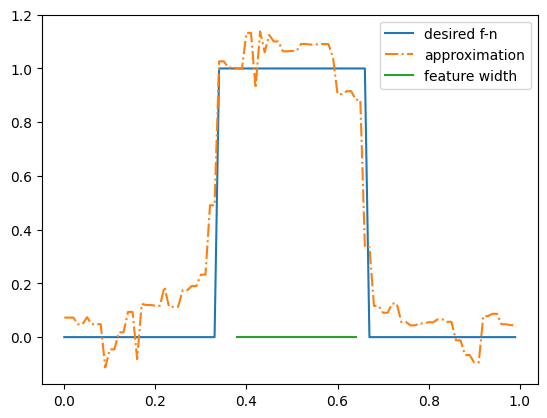

In [ ]:

w = np.zeros(shape= (num_segments,))

def model(x, w):
    encoding = within(x)
    return np.dot(w, encoding)

for _ in range(10600):
    s_test      = np.random.random()
    sol_model   = model(s_test, w)
    sol_true    = square_wave(s_test)
    x_i         = within(s_test)
    alpha       = 0.2 / x_i.sum()
    w += alpha * (sol_true - sol_model) * x_i

p_dom = np.arange(0,1,0.01)
#square_wave = np.vectorize(square_wave)
plt.plot(p_dom,[square_wave(a)  for a in p_dom] , label = 'desired f-n'  );
plt.plot(p_dom,[model(s, w)     for s in p_dom] , label = 'approximation', ls='-.');
plt.plot(start_end[num_segments//2], [0,0]      , label = 'feature width');
plt.legend()
plt.show()

Similar scripts also did not achieve good result. OG author may be hiding something!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

Implementation of tiling  with embeddings stored in a matrix

Added arbitrary offset between layers and arbitrary subdivision of tiles on each layer

average tile neighbors = 4.0


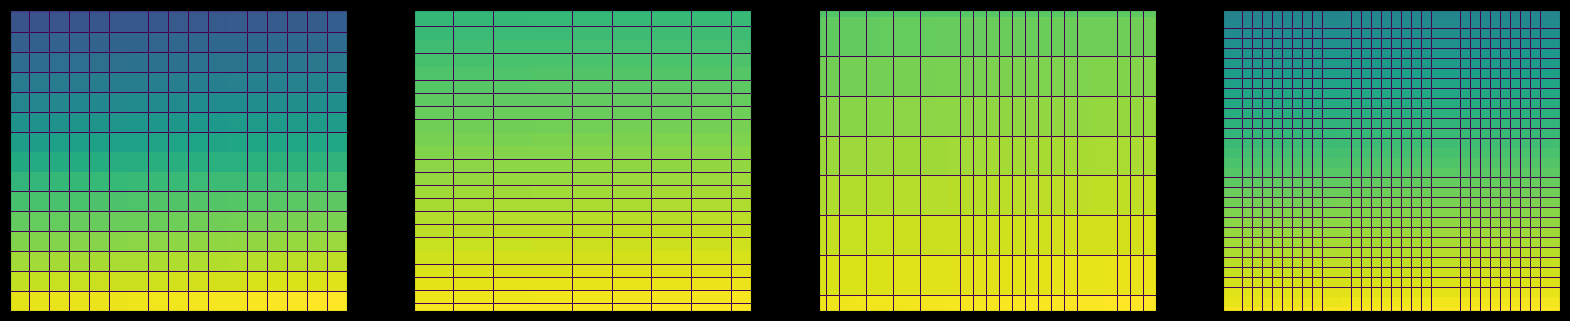

In [ ]:

t = tiles(tiles_x = [20,30,10,40], tiles_y = [20,10,30,40], layers = 4, offset = (0.08,0.05), max_entries_side = 1000)

dom_x = (0.0, 2.0 * np.pi)
dom_y = (0.0, 2.0 * np.pi)
t.embedding(dom_x,dom_y)
print(f'average tile neighbors = {t.M_embed.sum(-1).mean()}')
t.plot()


copy parts from https://github.com/MeepMoop/tilecoding/tree/master.

author there stores active tile IDs, so he subsets w[active_tiles] += delta

i keep one-hot/binary mask, so i mask delta with active_tiles-> w += delta*active_tiles
, which is more consistent with theory

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \hat v(S_t,\vec{w})\bigg]\cdot \vec{x}(S_t) }$$

(0.008522493166769118, -0.05822435928092631)

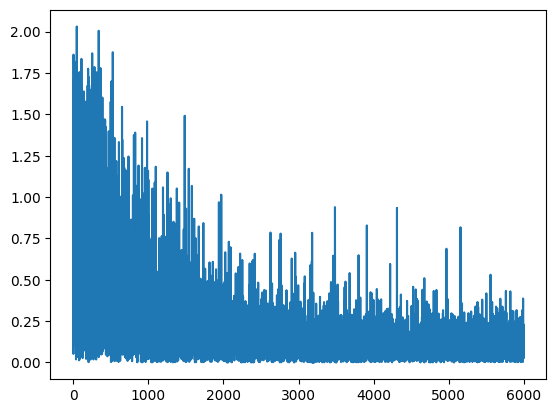

In [ ]:
def target_fn(x, y):
  return np.sin(x) + np.cos(y)

def target_fn_noisy(x, y):
  return target_fn(x, y) + 0.1 * np.random.randn()

perf = []
w = np.zeros(t.M_embed[0,0].size)
# step size for SGD
alpha = 0.2/3

# learn from 10,000 samples
for i in range(6000):
   # get noisy sample from target function at random location
  x, y = 2.0 * np.pi * np.random.rand(2)
  target = target_fn_noisy(x, y)
  # get prediction from active tiles at that location
  #active_tiles = get_embed(x,y)
  active_tiles = t.get_embed(x,y, oneHot=True)
  pred = np.dot(w, active_tiles)
  # update weights with SGD
  w += alpha * (target - pred)*active_tiles
  perf.append(np.abs(target - pred))


plt.plot(perf)


x, y = 2.0 * np.pi * np.random.rand(2)
target_fn(x, y), np.dot(w, t.get_embed(x,y))

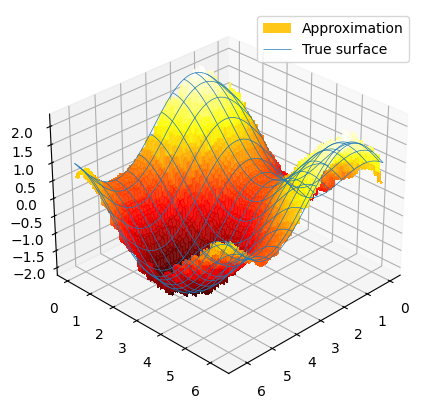

0.07101413170999503

In [ ]:
res = 400

x = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
y = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)

z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    z[j,i] = np.dot(w, t.get_embed(x[i], y[j]))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, z, cmap=plt.get_cmap('hot'), linewidth=1.5, antialiased=False, alpha = 0.9, label='Approximation')
Z = target_fn(X,Y)
ax.plot_wireframe(X, Y, Z, rstride=30, cstride=30, linewidth = 0.5, label='True surface')
ax.view_init(elev=30., azim=45)
plt.legend()
plt.show()

np.abs(Z-z).flatten().mean()

Update rule for $Q(s,a,\vec{w})$:
$$\vec{w} \leftarrow \vec{w} + \alpha[U - \hat q(S_\tau,A_\tau, w)] \nabla \hat q(S_\tau,A_\tau, w)$$
In case of linear approximation:
$$\hat q(s,a, \vec{w})= \hat q(s, \vec{w}_a) = \vec{w}_a^T \cdot \vec{x}(s) = \sum_{i = 1}^d w_i(a) x_i(s)$$ 
$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \vec{w}_{A_t}^T\cdot  \vec{x}(S_t)\bigg]\cdot \vec{x}(S_t)}$$

In case of simple mountain car env i have state space of velocity and position $S_x, S_v$ and 3 discrete actions no accel, accel left or right.

I can only discretize 2D space $(S_x, S_v)$, but for different actions, tile embedding is the same, so i can reuse them for each approximation.

$$\hat q(s,a, \vec{w}) = \sum_{i = 1}^d w_i(a) x_i(s)$$

Wrap my modified environment around approximation of Q. have to change how actions are sampled (because its not a matrix anymore)

_And i dont define a policy, because you have to create a discretization (but i think you can do it w/o tiling)__

In [17]:
class n_step_SARSA_APPROX(env_approx):
    def __init__(self, env_name, state_space_discrete, tile_params_d=None, eps=0.1, ALPHA=0.05, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_space_discrete, tile_params_d, eps, ALPHA, GAMMA, *args, **kwargs)

    def update_Wq(self, target, state, action):
        self.Wq[action] += self.ALPHA*(target - self.Qsa(action,state))*self.Xs(state)

tx = ty = 40
tn = 8
tp = {'tiles_x' : tx, 'tiles_y' : ty, 'layers' : tn, 'offset' : [1/tx/tn]*2, 'max_entries_side' : 600}
en = None
en = n_step_SARSA_APPROX('MountainCar-v0',state_space_discrete=False, tile_params_d = tp, GAMMA = 1, ALPHA = 1/2/8)


In [18]:
def n_step_SARSA_APPROX_Loop(env: n_step_SARSA_APPROX, n = 5, N = 1, GAMMA = 1, ALPHA = 0.01):
    times = []
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        env.env_iters += 1
        t = 0
        St                       = env.reset()    
        At                       = env.sample_action(St)
        states, actions, rewards = [St],[At],[-1000]
        T = float("inf")
        while True:
            if t < T:
                St1, Rt1, St1_terminal   = env.step(At)
                states.append(St1)
                rewards.append(Rt1)
                if St1_terminal:
                    T = t + 1
                else:
                    At1  = env.sample_action(St1)
                    actions.append(At1)
                    At = At1
            tau = t - n + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rewards[i] for i in range(tau+1, min(tau+n,T) + 1)])
                if tau + n < T:
                    G += GAMMA**n*env.Qsa(actions[tau+n],states[tau+n])
                env.update_Wq(G, states[tau], actions[tau])
                
            t += 1
            if tau == T - 1:
                times.append(T)
                tq_iter.set_postfix(eps=env.eps, T = T, env_iters = env.env_iters)
                break
        
    return times

perf = n_step_SARSA_APPROX_Loop(en, n = 4, N = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 2000/2000 [04:21<00:00,  7.66it/s, T=154, env_iters=1999, eps=0.1]


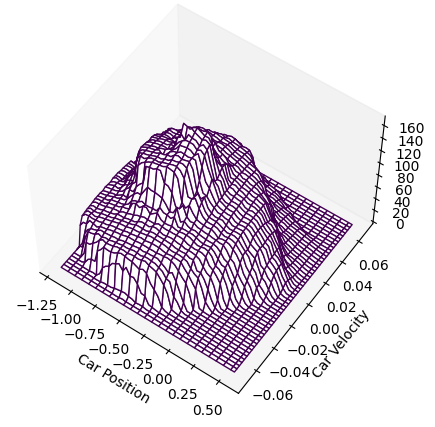

In [19]:
low                 = en.env.observation_space.low
high                = en.env.observation_space.high
minmax_x, minmax_y  = np.vstack((low,high)).T
x = np.arange(*minmax_x, (minmax_x[1]- minmax_x[0])/50)
y = np.arange(*minmax_y, (minmax_y[1]- minmax_y[0])/50)

z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    val = np.array([en.Qsa(a, (x[i], y[j])) for a in en.actions]).max()
    z[i,j] = val #en.Qsa(2, (x[i], y[j]))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, -z.T, rstride=1, cstride=2, shade=False, cmap=None, linewidth=1, label='Approximation')
surf.set_edgecolors(surf.to_rgba(surf._A))
surf.set_facecolors("white")
#wire = ax.plot_wireframe(X, Y, -z.T, rstride=2, cstride=5, linewidth = 0.5, label='True surface')
ax.view_init(elev=55., azim=-55)

ax.grid(False)
ax.set_xlabel('Car Position')
ax.set_ylabel('Car Velocity');

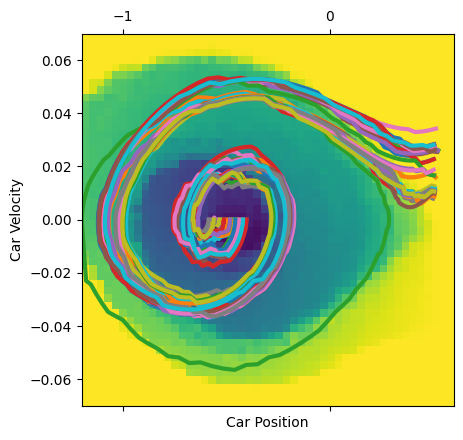

In [20]:
N = 30
plt.matshow(z.T, extent=[*minmax_x,*minmax_y])
for _ in range(N): 
    St                       = en.reset()    
    At                       = en.sample_action(St)
    states = [St]
    T = float("inf")
    while True:
        St1, Rt1, St1_terminal   = en.step(At)
        states.append(St1)
        At1  = en.sample_action(St1)
        At = At1
        if St1_terminal:break
    states = np.array(states)
    plt.plot(*states.T, linewidth = 3)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('Car Position')
plt.gca().set_ylabel('Car Velocity');